# The Simple Harmonic Oscillator

Here we will expand on the harmonic oscillator first shown in the getting started script. I'll walk you through some of the features of desolver and hopefully give a better a sense of how to use the software.

So let's begin!

First we import the libraries we'll need. I import all the matplotlib machinery using the magic command `%matplotlib`, but this is only for notebook/ipython environments.

Then I import `desolver` and the desolver backend as well (this will be useful for specifying our problem), and set the default datatype to `float64`.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import desolver as de
import desolver.backend as D

D.set_float_fmt('float64')

PyAudi backend is available.
Using numpy backend


## Specifying the Dynamical System

Now let's specify the right hand side of our dynamical system. It should be

$$
\frac{\mathrm{d^2}x}{\mathrm{dt}^2} = -\frac{k}{m} x
$$

But desolver only works with first order differential equations, thus we must cast this into a first order system before we can solve it. Thus we obtain the following system

$$
\begin{array}{l}
\frac{\mathrm{d}x}{\mathrm{dt}} = v_x \\
\frac{\mathrm{d}v_x}{\mathrm{dt}} = -\frac{k}{m} x
\end{array}
$$

which can be specified as a simple matrix equation as

$$
\begin{array}{c}
\frac{\mathrm{d}y}{\mathrm{dt}} = \begin{bmatrix}
   0            & 1 \\
   -\frac{k}{m} & 0
   \end{bmatrix} \cdot \vec y \\
\vec y = \begin{bmatrix}x \\ v_x\end{bmatrix}
\end{array}
$$

In [2]:
@de.rhs_prettifier(
    equ_repr="[vx, -k*x/m]",
    md_repr=r"""
$$
\frac{\mathrm{d}y}{\mathrm{dt}} = \begin{bmatrix}
   0            & 1 \\
   -\frac{k}{m} & 0
   \end{bmatrix} \cdot \vec y
$$
"""
)
def rhs(t, state, k, m, **kwargs):
    return D.array([[0.0, 1.0], [-k/m,  0.0]])@state

First thing to notice is that we used the backend to specify the matrix and minimise the use of numpy specific machinery. This isn't necessary if you only use numpy, but by doing this we can make this code run with the pytorch backend with minimal effort.

Second thing is the use of the decorator `@de.rhs_prettifier`, this is a convenience decorator that allows me to specify a text representation of the differential equations. Convenient if I want to print it

In [3]:
print(rhs)

[vx, -k*x/m]


Or if I want it to look pretty when it is rendered in the notebook

In [4]:
display(rhs)


$$
\frac{\mathrm{d}y}{\mathrm{dt}} = \begin{bmatrix}
   0            & 1 \\
   -\frac{k}{m} & 0
   \end{bmatrix} \cdot \vec y
$$


Let's specify the initial conditions as well

In [5]:
y_init = D.array([1., 0.])

And now we're ready to integrate!

## The Numerical Integration

There are a number of things we must choose before we numerically integrate our system of equations. The first of these is whether or not we want an interpolating spline so that we can compute the state of our system between timesteps. The second is the duration of the numerical integration. And the third is the value of parameters of the system: `k` and `m`. 

Unlike scipy, desolver let's you specify a dictionary of constants that are passed to the `rhs` function and can be modified even after constructing the `OdeSystem` object. This is particularly useful if you want to vary a single constant over multiple integrations without changing any other parameters.

Now, we'll set the numerical integration to 1 cycle of the oscillator at `k=1` and `m=1` which, when computed from the formula $T=2\pi\sqrt{\frac{k}{m}}$, is exactly $2\pi$.

In [6]:
a = de.OdeSystem(rhs, y0=y_init, dense_output=True, t=(0, 2*D.pi), dt=0.01, rtol=1e-9, atol=1e-9, constants=dict(k=1.0, m=1.0))

In [7]:
a.integrate()

Since `k=1` and `m=1` and we integrated for 1 cycle, we expect that the final state of the system is the same as the initial state.

In [8]:
print("initial state = {}".format(a[0].y))
print("final state   = {}".format(a[-1].y))
print("maximum absolute difference = {}".format(D.max(D.abs(a[-1].y - a[0].y))))

initial state = [1. 0.]
final state   = [ 1.00000000e+00 -1.14580831e-10]
maximum absolute difference = 3.2781628522826622e-09


Wonderful! We see that the final state is almost exactly the same. Furthermore, we see that this is within the tolerances we specified when creating the `OdeSystem` where we set `rtol` and `atol` to `1e-9`.

To show you that this is not a fluke, we'll change them to `1e-12` and see what happens.

In [9]:
a.rtol = 1e-12
a.atol = 1e-12
a.reset()
a.integrate()

In [10]:
print("initial state = {}".format(a[0].y))
print("final state   = {}".format(a[-1].y))
print("maximum absolute difference = {}".format(D.max(D.abs(a[-1].y - a[0].y))))

initial state = [1. 0.]
final state   = [ 1.00000000e+00 -2.84841595e-14]
maximum absolute difference = 3.2589486664846845e-12


It's very simple to change the tolerances and rerun the system. Furthermore, we can update our constants and see what happens.

If we quadruple `k`, the spring constant, the period will double, and so after an integration period of $2\pi$ the system should, yet again, be in a final state that is almost exactly the initial state.

In [11]:
a.consts['k'] = a.consts['k'] * 4
a.reset()
a.integrate()

In [12]:
print("initial state = {}".format(a[0].y))
print("final state   = {}".format(a[-1].y))
print("maximum absolute difference = {}".format(D.max(D.abs(a[-1].y - a[0].y))))

initial state = [1. 0.]
final state   = [ 1.00000000e+00 -1.69343706e-13]
maximum absolute difference = 9.037215420448774e-12


The final state is again almost the same as the initial state, but now the maximum absolute difference has increased. This is due to the fact that the numerical error when using an adaptive runge-kutta method is not a random walk, but a function of the whole numerical procedure. Thus if we double the initial integration time, and set `k=1` again, we'll see that the error is larger.

In [13]:
a.consts['k'] = 1
a.tf = 4*D.pi
a.reset()
a.integrate()

In [14]:
print("initial state = {}".format(a[0].y))
print("final state   = {}".format(a[-1].y))
print("maximum absolute difference = {}".format(D.max(D.abs(a[-1].y - a[0].y))))

initial state = [1. 0.]
final state   = [ 1.00000000e+00 -5.67506112e-14]
maximum absolute difference = 6.517675288364444e-12


The longer we integrate for, the larger this error will become. Is there anything we can do?

**YES**

We can use a symplectic integrator since this is a system with a Hamiltonian $H=\frac{kx^2}{2} + \frac{mv_x^2}/2$.

A symplectic integrator preserves the symplectic two-form $\mathrm{d}\vec p \wedge\mathrm{d}\vec q$ where $p$ is the momentum and $q$ is the position such that

$$
\begin{array}{l}
\frac{\mathrm{d}p}{\mathrm{dt}} = -\frac{\partial H}{\partial q} \\
\frac{\mathrm{d}q}{\mathrm{dt}} = \frac{\partial H}{\partial p}
\end{array}
$$

where, in our case, $v_x = \frac{p}{m}$ and $x = q$.

Why is this important? I'll leave the detailed theory to [Wikipedia](https://en.wikipedia.org/wiki/Symplectic_integrator) and other sources, but the jist of it is that a symplectic integrator is essentially a geometric transformation in the phase space of the system and thus preserves the differential volume element of a Hamiltonian that is almost, but not quite, the Hamiltonian of the system.

This is great because it means that, in the best case scenario, the errors in the numerically integrated states are random walks instead of increasing linearly with the integration time. The downside is that a symplectic integrator is not adaptive and thus requires more function evaluations than a Runge-Kutta method.

In [15]:
a.set_method("BABS9O7H")
a.dt = 0.05
a.tf = 2*D.pi
a.integrate()

An integration was already run, the system will be reset


In [16]:
print("initial state = {}".format(a[0].y))
print("final state   = {}".format(a[-1].y))
print("maximum absolute difference = {}".format(D.max(D.abs(a[-1].y - a[0].y))))

initial state = [1. 0.]
final state   = [ 1.0000000e+00 -2.7269853e-15]
maximum absolute difference = 2.7269853042355408e-15


In [17]:
a.set_method("BABS9O7H")
a.dt = 0.05
a.tf = 8*D.pi
a.integrate()

An integration was already run, the system will be reset


In [18]:
print("initial state = {}".format(a[0].y))
print("final state   = {}".format(a[-1].y))
print("maximum absolute difference = {}".format(D.max(D.abs(a[-1].y - a[0].y))))

initial state = [1. 0.]
final state   = [ 1.00000000e+00 -9.48546797e-15]
maximum absolute difference = 9.485467966641181e-15


In [19]:
a.set_method("BABS9O7H")
a.dt = 0.05
a.tf = 32*D.pi
a.integrate()

An integration was already run, the system will be reset


In [20]:
print("initial state = {}".format(a[0].y))
print("final state   = {}".format(a[-1].y))
print("maximum absolute difference = {}".format(D.max(D.abs(a[-1].y - a[0].y))))

initial state = [1. 0.]
final state   = [ 1.00000000e+00 -4.41313652e-14]
maximum absolute difference = 4.413136522884997e-14


Above, I've run the numerical integration using a step size of $0.05$ for increasing integration periods from one cycle to four cycles to sixteen cycles and, despite that, the error has stayed near the limits of double precision arithmetic. If I further integrate for 1024 cycles, we'll see that the error begins to increase and this is expected because although the errors in each step may be random walks, they have a cumulative effect that is not necessarily a random walk. 

In [21]:
a.set_method("BABS9O7H")
a.dt = 0.05
a.tf = 2*1024*D.pi
a.integrate()

An integration was already run, the system will be reset


In [22]:
print("initial state = {}".format(a[0].y))
print("final state   = {}".format(a[-1].y))
print("maximum absolute difference = {}".format(D.max(D.abs(a[-1].y - a[0].y))))

initial state = [1. 0.]
final state   = [ 1.00000000e+00 -2.06966388e-12]
maximum absolute difference = 2.069663884718409e-12


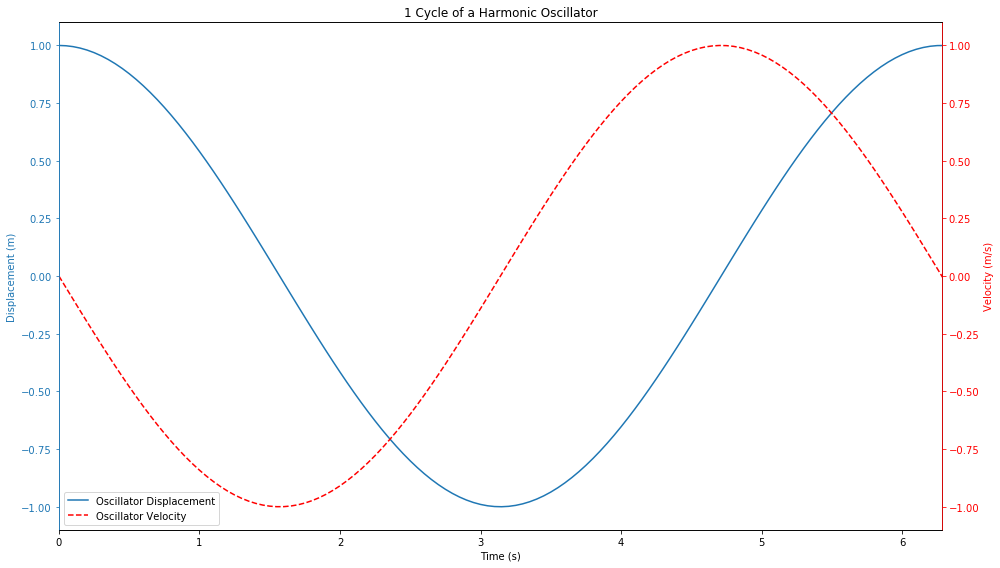

In [23]:
fig = plt.figure(figsize=(14,8))
ax  = fig.add_subplot(111)

displn = ax.plot(a.t, a.y[:, 0], label="Oscillator Displacement", color='C0')
axt = ax.twinx()
velln  = axt.plot(a.t, a.y[:, 1], label="Oscillator Velocity", color='red', linestyle='--')

ax.set_xlabel("Time (s)")
ax.set_ylabel("Displacement (m)")
axt.set_ylabel("Velocity (m/s)")
ax.set_xlim(0, 2*D.pi)

ax.spines['left'].set_color('C0')
ax.tick_params(axis='y', colors='C0')
ax.yaxis.label.set_color('C0')

axt.spines['right'].set_color('red')
axt.spines['left'].set_color('C0')
axt.tick_params(axis='y', colors='red')
axt.yaxis.label.set_color('red')

# added these three lines
lns = displn + velln
labs = [l.get_label() for l in lns]
ax.legend(lns, labs)

ax.set_title("1 Cycle of a Harmonic Oscillator")
plt.tight_layout()